In [1]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
x = torch.zeros(5)
index = torch.tensor([0, 2, 4, 1, 3])
src = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])
x.scatter_add_(0, index, src)
print(x)  

tensor([1., 4., 2., 5., 3.])


In [3]:
x = torch.zeros(3, 5)
index = torch.tensor([[0, 1,0], [2, 3, 4], [2, 3, 4]])
src = torch.tensor([[1.0, 2.0,0], [4.0, 5.0, 6.0],[4.0, 5.0, 6.0]])
x.scatter_add_(1, index, src)
print(x)

tensor([[1., 2., 0., 0., 0.],
        [0., 0., 4., 5., 6.],
        [0., 0., 4., 5., 6.]])


In [4]:
x = torch.zeros(2, 10, 2)
index = torch.tensor([[[0, 0], [0, 0], [0, 0]],
                      [[3, 3], [4, 4], [5, 5]]])
src = torch.tensor([[[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]],
                    [[7.0, 8.0], [9.0, 10.0], [11.0, 12.0]]])
x.scatter_add_(index=index, src=src,dim=1)
print(x)

tensor([[[ 9., 12.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 7.,  8.],
         [ 9., 10.],
         [11., 12.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]]])


In [5]:
batch_size=2
in_channels=2
edges_index=torch.tensor([[[0,0],[1,0],[2,0],[3,0]],[[0,0],[0,1],[2,1],[3,1]]],dtype=torch.int64)

nodes=torch.tensor([[[0,1],[1,2],[2,2,],[3,3]],[[8,8],[9,9],[10,10],[11,11]]],dtype=torch.float32)
distances=torch.tensor([[1,1,1/2,1/3],[1,1/6,1/7,1/8]],dtype=torch.float32)

src, target = edges_index[..., 0], edges_index[..., 1]

print(f"nodes:{tuple(nodes.shape)}")
print(f"distances:{tuple(distances.shape)}")
print(f"src:{tuple(src.shape)}")

nodes_src = nodes[torch.arange(batch_size).unsqueeze(1),src]
print(f"nodes src:{tuple(nodes_src.shape)}")
message = torch.einsum("bei,be->bei", nodes_src, distances)
print(f"message: {tuple(message.shape)}")
print(message)
out = torch.zeros_like(nodes)

out.scatter_add_(dim=1, src=message, index=target.unsqueeze(
    2).repeat(1, 1,in_channels))

print(f"out: {tuple(out.shape)}")
print(out)

nodes:(2, 4, 2)
distances:(2, 4)
src:(2, 4)
nodes src:(2, 4, 2)
message: (2, 4, 2)
tensor([[[0.0000, 1.0000],
         [1.0000, 2.0000],
         [1.0000, 1.0000],
         [1.0000, 1.0000]],

        [[8.0000, 8.0000],
         [1.3333, 1.3333],
         [1.4286, 1.4286],
         [1.3750, 1.3750]]])
out: (2, 4, 2)
tensor([[[3.0000, 5.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[8.0000, 8.0000],
         [4.1369, 4.1369],
         [0.0000, 0.0000],
         [0.0000, 0.0000]]])


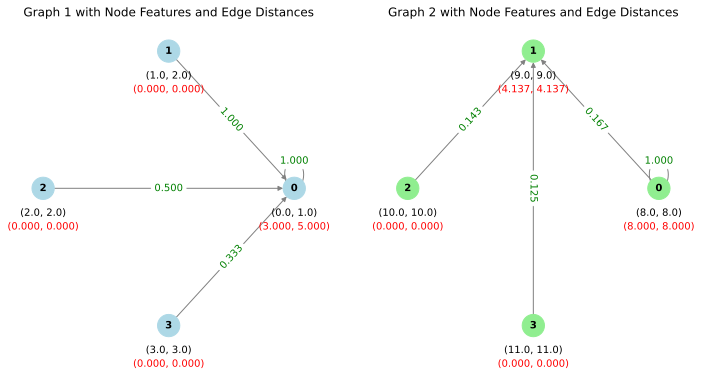

In [6]:
G1 = nx.DiGraph()  
G2 = nx.DiGraph()  

for b in range(len(nodes)):
    if b == 0:  
        for node_idx, node_feat in enumerate(nodes[b]):
            G1.add_node(f'{node_idx}', feature=node_feat)  
        for edge_idx, edge in enumerate(edges_index[b]):
            node_a, node_b = edge
            G1.add_edge(f'{node_a.item()}', f'{node_b.item()}') 
    else: 
        for node_idx, node_feat in enumerate(nodes[b]):
            G2.add_node(f'{node_idx}', feature=node_feat)  
        for edge_idx, edge in enumerate(edges_index[b]):
            node_a, node_b = edge
            G2.add_edge(f'{node_a.item()}', f'{node_b.item()}')  


pos1 = nx.circular_layout(G1)  
pos2 = nx.circular_layout(G2)  


plt.figure(figsize=(12, 6)) 


plt.subplot(1, 2, 1)  
nx.draw(G1, pos1, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')


for node, (x, y) in pos1.items():
    node_feat = G1.nodes[node]['feature']
    label = f"({node_feat[0].item()}, {node_feat[1].item()})"
    plt.text(x, y-0.2, label,fontsize=10, ha='center')
for node, (x, y) in pos1.items():
    extra_feat = out[0][int(node), :] 
    label = f"({extra_feat[0].item():.3f}, {extra_feat[1].item():.3f})"
    plt.text(x, y -0.3, label, color='red', fontsize=10, ha='center')

edge_labels = {}
for idx, (node_a, node_b) in enumerate(G1.edges()):
    distance = distances[0][idx].item() 
    edge_labels[(node_a, node_b)] = f"{distance:.3f}" 

nx.draw_networkx_edge_labels(G1, pos1, edge_labels=edge_labels, font_size=10, font_color='green')
plt.title("Graph 1 with Node Features and Edge Distances")


plt.subplot(1, 2, 2)  
nx.draw(G2, pos2, with_labels=True, node_size=500, node_color='lightgreen', font_size=10, font_weight='bold', edge_color='gray')

for node, (x, y) in pos2.items():
    node_feat = G2.nodes[node]['feature']
    label = f"({node_feat[0].item()}, {node_feat[1].item()})"
    plt.text(x, y-0.2, label,  fontsize=10, ha='center')
for node, (x, y) in pos2.items():
    extra_feat = out[1][int(node), :] 
    label = f"({extra_feat[0].item():.3f}, {extra_feat[1].item():.3f})"
    plt.text(x, y -0.3, label, color='red', fontsize=10, ha='center')

edge_labels = {}
for idx, (node_a, node_b) in enumerate(G2.edges()):
    distance = distances[1][idx].item()  
    edge_labels[(node_a, node_b)] = f"{distance:.3f}" 

nx.draw_networkx_edge_labels(G2, pos2, edge_labels=edge_labels, font_size=10, font_color='green')
plt.title("Graph 2 with Node Features and Edge Distances")

plt.show()
